In [2]:
import numpy as np
import torch
import esm
import networkx as nx
import hypernetx as hnx
import matplotlib.pyplot as plt

In [9]:
model, alphabet = esm.pretrained.esm1b_t33_650M_UR50S()

In [10]:
sequence = "MSHHWGYGKHNGPEHWHKDFPIAKGERQSPVDIDTHTAKYDPSLKPLSVSYDQATSLRILNNGHAFNVEFDDSQDKAVLKGGPLDGTYRLIQFHFHWGSLDGQGSEHTVDKKKYAAELHLVHWNTKYGDFGKAVQQPDGLAVLGIFLKVGSAKPGLQKVVDVLDSIKTKGKSADFTNFDPRGLLPESLDYWTYPGSLTTPPLLECVTWIVLKEPISVSSEQVLKFRKLNFNGEGEPEELMVDNWRPAQPLKNRQIKASFK"


In [11]:
# --- Sequenz und Batch-Converter -------------------------------
batch_converter = alphabet.get_batch_converter()
_, _, batch_tokens = batch_converter([("P00918", sequence)])

# --- Kontaktvorhersage -----------------------------------------
with torch.no_grad():
    results = model(batch_tokens, repr_layers=[33], return_contacts=True)
contact_map = results["contacts"][0]

In [12]:
contact_map

tensor([[5.0700e-02, 1.4922e-01, 5.7543e-03,  ..., 9.0072e-03, 1.2686e-02,
         1.8058e-02],
        [1.4922e-01, 1.9535e-01, 1.1364e-03,  ..., 7.4170e-03, 8.5067e-03,
         9.1978e-03],
        [5.7543e-03, 1.1364e-03, 5.6415e-04,  ..., 7.3950e-03, 8.5850e-03,
         7.8741e-03],
        ...,
        [9.0072e-03, 7.4170e-03, 7.3950e-03,  ..., 1.3410e-02, 3.4597e-03,
         3.3610e-02],
        [1.2686e-02, 8.5067e-03, 8.5850e-03,  ..., 3.4597e-03, 1.7206e-07,
         1.9202e-07],
        [1.8058e-02, 9.1978e-03, 7.8741e-03,  ..., 3.3610e-02, 1.9202e-07,
         2.6606e-01]])

In [13]:
def build_protein_hypergraph_from_contact_map(contact_map: np.ndarray,
                                              sequence: str,
                                              threshold: float = 0.5,
                                              trade_name: str = "P00918",
                                              plot: bool = True):
    """
    Builds a protein hypergraph from ESM-predicted contact probabilities, ensuring unique hyperedges.

    Args:
        contact_map (np.ndarray): L×L matrix of contact probabilities.
        sequence (str): Protein sequence of length L.
        threshold (float): Probability cutoff to include contacts.
        trade_name (str): Identifier for plot title.
        plot (bool): Whether to visualize the hypergraph.

    Returns:
        hyperedges (dict): Mapping edge_id → tuple of residue indices.
        node_labels (dict): Mapping residue index → amino acid letter.
    """
    L = contact_map.shape[0]

    # 1) Build and deduplicate hyperedges on the fly
    seen_sets = set()
    hyperedges = {}
    edge_counter = 0
    for i in range(L):
        partners = np.where(contact_map[i] >= threshold)[0].tolist()
        if partners:
            nodes = tuple(sorted({i, *partners}))
            fs = frozenset(nodes)
            if fs not in seen_sets:
                seen_sets.add(fs)
                hyperedges[f"he_{edge_counter}"] = nodes
                edge_counter += 1

    # 2) Add a global hyperedge spanning all residues
    all_nodes = tuple(range(L))
    if frozenset(all_nodes) not in seen_sets:
        hyperedges[f"he_{edge_counter}"] = all_nodes
        edge_counter += 1

    # 3) Node labels: amino acid letters
    node_labels = {i: sequence[i] for i in range(L)}

    # 4) Optional visualization with customizable draw parameters
    if plot:
        H = hnx.Hypergraph(hyperedges)
        plt.figure(figsize=(40, 24))  # Increased figure size for better readability
        hnx.draw(
            H,
            with_node_labels=True,
            node_labels=node_labels,
            with_edge_labels=True,
        )
        plt.title(f"Hypergraph of {trade_name}")
        plt.show()

    return hyperedges, node_labels

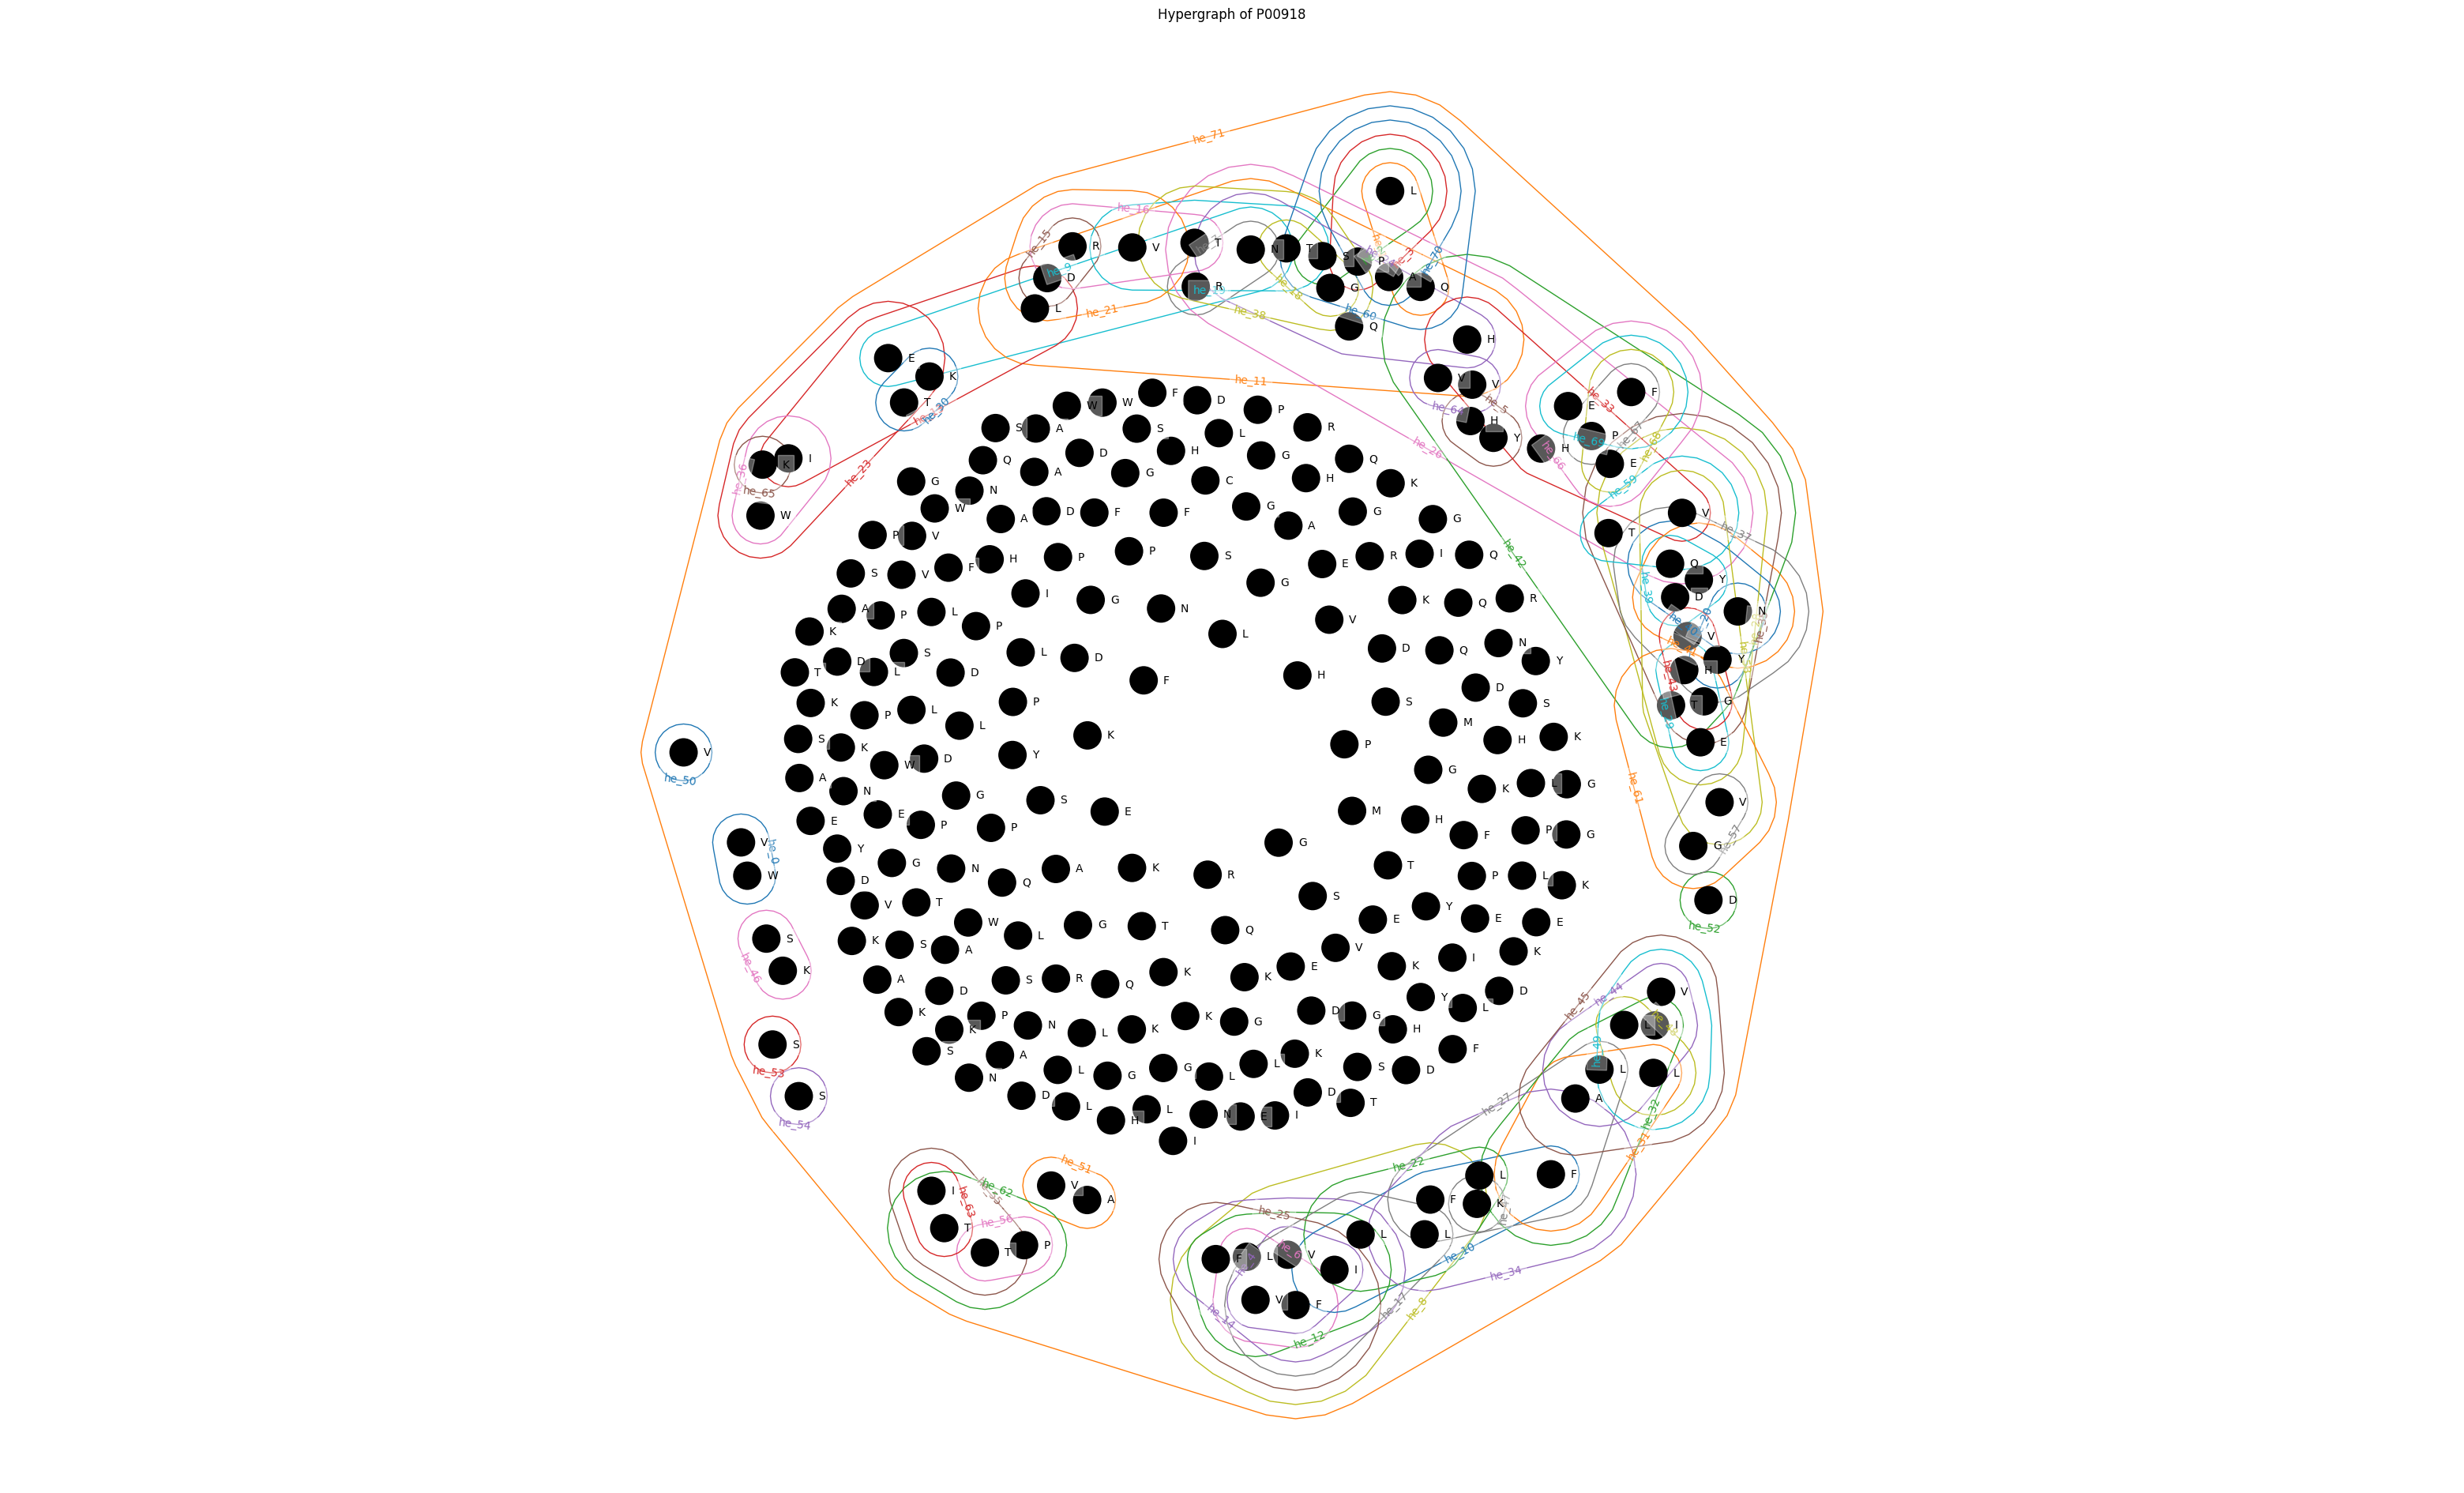

In [14]:
hyperedges, node_labels = build_protein_hypergraph_from_contact_map(contact_map, sequence)

In [15]:
len(node_labels)

260